<a href="https://colab.research.google.com/github/tasfia490/tasfia490/blob/main/a0016fileemd0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy scipy pyemd pywavelets matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.6/662.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.signal as signal
import pywt
import matplotlib.pyplot as plt
from PyEMD import EMD
import warnings

# -------------------------------------------------------------------------------------------
# Parameters
# -------------------------------------------------------------------------------------------
audio_file = 'a0400.wav'  # Replace with your audio file name
channel_to_process = 1        # Set to 0 or 1 depending on which channel to process (Python indexing starts at 0)
segment_duration = 5          # Segment length in seconds
fs = 44100  # Adjust this based on your audio file sampling rate

# -------------------------------------------------------------------------------------------
# Load the Recorded Audio File
# -------------------------------------------------------------------------------------------
from scipy.io.wavfile import read
audio_file = 'p2s1_converted.wav'
audio = AudioSegment.from_file(audio_file, format="aac")
fs, audio_data = read(audio_file)  # Load your audio file
audio_data = audio_data / np.max(np.abs(audio_data))  # Normalize audio data


# Validate the selected channel
if audio_data.ndim == 1:  # Single channel audio
    selected_channel_data = audio_data
elif channel_to_process >= audio_data.shape[1]:
    raise ValueError(f"The audio file does not have channel {channel_to_process + 1}. It has {audio_data.shape[1]} channel(s).")
else:
    selected_channel_data = audio_data[:, channel_to_process]

# Define total duration of the audio
num_samples = len(selected_channel_data)
total_duration = num_samples / fs
num_segments = int(np.ceil(total_duration / segment_duration))

# Cell array to store all IMFs
all_imfs_fetal = []
all_imfs_variance = []  # Array to store variances for IMFs

# -------------------------------------------------------------------------------------------
# Process each 5-second segment independently and analyze
# -------------------------------------------------------------------------------------------
for seg in range(num_segments):
    # Define the start and end indices of the current segment
    start_idx = int(seg * segment_duration * fs)
    end_idx = min(int((seg + 1) * segment_duration * fs), num_samples)

    current_segment = selected_channel_data[start_idx:end_idx]

    # -------------------------------------------------------------------------------------------
    # Apply EMD to the Current Segment
    # -------------------------------------------------------------------------------------------
    try:
        # Remove DC Offset (Detrend)
        data = signal.detrend(current_segment)

        # Perform Empirical Mode Decomposition (EMD)
        emd = EMD()
        imfs = emd.emd(data)

        # Apply noise filtering on each IMF using a combination of filtering techniques
        filtered_imfs = []
        for imf in imfs:
            # Low-pass filter each IMF to reduce high-frequency noise
            lowpassed_imf = signal.filtfilt(*signal.butter(4, 10, fs=fs, btype='low'), imf)

            # Apply wavelet denoising (Daubechies 4 wavelet)
            coeffs = pywt.wavedec(lowpassed_imf, 'db4', level=4)
            threshold = 0.2 * np.median(np.abs(coeffs[0]))
            coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
            denoised_imf = pywt.waverec(coeffs, 'db4')

            filtered_imfs.append(denoised_imf)

        filtered_imfs = np.array(filtered_imfs)

        # Store the IMFs for this segment in a list
        all_imfs_fetal.append(filtered_imfs)

        # Calculate and store the variance of each IMF for ranking
        variances = np.var(filtered_imfs, axis=1)
        all_imfs_variance.append(variances)
    except Exception as e:
        warnings.warn(f"EMD failed for segment {seg + 1}: {e}")
        continue  # Skip this segment if EMD fails

# -------------------------------------------------------------------------------------------
# Identify the Top 10 IMFs Based on Variance
# -------------------------------------------------------------------------------------------
# Combine variances with segment and IMF indices
imf_variance_data = []
for seg_idx, variances in enumerate(all_imfs_variance):
    for imf_idx, var in enumerate(variances):
        imf_variance_data.append((seg_idx + 1, imf_idx + 1, var))  # 1-based indexing

# Sort by variance in descending order
imf_variance_data = sorted(imf_variance_data, key=lambda x: -x[2])

# Select the top 10 IMFs
top_10_imfs = imf_variance_data[:10]

# -------------------------------------------------------------------------------------------
# Display the Top IMFs in Separate Figures
# -------------------------------------------------------------------------------------------
for i, (seg, imf_idx, _) in enumerate(top_10_imfs, 1):
    imfs = all_imfs_fetal[seg - 1]  # Retrieve the IMFs for the segment
    t_imf = np.arange(len(imfs[imf_idx - 1])) / fs  # Time vector for the IMF

    # Create a new figure for the IMF
    plt.figure()
    plt.plot(t_imf, imfs[imf_idx - 1], linewidth=1.5)
    plt.title(f"Top IMF {i} from Segment {seg}\nFile: {audio_file}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.show()
print("Analysis complete.")


In [2]:
pip install PyWavelets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
pip install EMD-signal


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00


In [7]:
pip install pydub


In [10]:
pip install ffmpeg


  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=e6fd1fe5c1ae42a6bb027b10bcf1e0fbcb596904ad7745562b687c0077dc425f
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [14]:
pip install pydub ffmpeg numpy scipy pywt PyEMD matplotlib


ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [19]:
pip install PyWavelets


In [21]:
import numpy as np
import scipy.signal as signal
import pywt
import matplotlib.pyplot as plt
from PyEMD import EMD
import warnings
from pydub import AudioSegment
from scipy.io.wavfile import read

# -------------------------------------------------------------------------------------------
# Convert AAC to WAV
# -------------------------------------------------------------------------------------------
audio_file = 'p2s1 (2).aac'  # Replace with your AAC file name
wav_file = 'p2s1_converted.wav'

# Load AAC and export as WAV
audio = AudioSegment.from_file(audio_file, format="aac")
audio.export(wav_file, format="wav")

# -------------------------------------------------------------------------------------------
# Parameters
# -------------------------------------------------------------------------------------------
channel_to_process = 0        # Python indexing starts at 0
segment_duration = 5          # Segment length in seconds

# -------------------------------------------------------------------------------------------
# Load the Converted WAV File
# -------------------------------------------------------------------------------------------
fs, audio_data = read(wav_file)  # Load WAV file
audio_data = audio_data / np.max(np.abs(audio_data))  # Normalize audio data

# Validate the selected channel
if audio_data.ndim == 1:  # Single channel audio
    selected_channel_data = audio_data
elif channel_to_process >= audio_data.shape[1]:
    raise ValueError(f"The audio file does not have channel {channel_to_process + 1}. It has {audio_data.shape[1]} channel(s).")
else:
    selected_channel_data = audio_data[:, channel_to_process]

# Define total duration of the audio
num_samples = len(selected_channel_data)
total_duration = num_samples / fs
num_segments = int(np.ceil(total_duration / segment_duration))

# -------------------------------------------------------------------------------------------
# Process the Audio and Analyze
# -------------------------------------------------------------------------------------------
# (Your original processing code for EMD and IMF analysis comes here.)
# -------------------------------------------------------------------------------------------

print("Processing complete.")


Processing complete.


In [23]:
import numpy as np
import scipy.signal as signal
import pywt
import matplotlib.pyplot as plt
from PyEMD import EMD
from pydub import AudioSegment
import warnings

# -------------------------------------------------------------------------------------------
# Parameters
# -------------------------------------------------------------------------------------------
audio_file = 'p2s1 (2).aac'  # Replace with your audio file name
wav_file = 'converted_audio.wav'  # Temporary WAV file for processing
channel_to_process = 0        # Set to 0 or 1 depending on which channel to process (Python indexing starts at 0)
segment_duration = 5          # Segment length in seconds

# -------------------------------------------------------------------------------------------
# Convert AAC to WAV
# -------------------------------------------------------------------------------------------
audio = AudioSegment.from_file(audio_file, format="aac")
audio.export(wav_file, format="wav")  # Convert AAC to WAV

# -------------------------------------------------------------------------------------------
# Load the Converted Audio File
# -------------------------------------------------------------------------------------------
from scipy.io.wavfile import read

fs, audio_data = read(wav_file)  # Load the converted WAV file
audio_data = audio_data / np.max(np.abs(audio_data))  # Normalize audio data

# Validate the selected channel
if audio_data.ndim == 1:  # Single channel audio
    selected_channel_data = audio_data
elif channel_to_process >= audio_data.shape[1]:
    raise ValueError(f"The audio file does not have channel {channel_to_process + 1}. It has {audio_data.shape[1]} channel(s).")
else:
    selected_channel_data = audio_data[:, channel_to_process]

# Define total duration of the audio
num_samples = len(selected_channel_data)
total_duration = num_samples / fs
num_segments = int(np.ceil(total_duration / segment_duration))

# Cell array to store all IMFs
all_imfs_fetal = []
all_imfs_variance = []  # Array to store variances for IMFs

# -------------------------------------------------------------------------------------------
# Process each 5-second segment independently and analyze
# -------------------------------------------------------------------------------------------
for seg in range(num_segments):
    # Define the start and end indices of the current segment
    start_idx = int(seg * segment_duration * fs)
    end_idx = min(int((seg + 1) * segment_duration * fs), num_samples)

    current_segment = selected_channel_data[start_idx:end_idx]

    # -------------------------------------------------------------------------------------------
    # Apply EMD to the Current Segment
    # -------------------------------------------------------------------------------------------
    try:
        # Remove DC Offset (Detrend)
        data = signal.detrend(current_segment)

        # Perform Empirical Mode Decomposition (EMD)
        emd = EMD()
        imfs = emd.emd(data)

        # Apply noise filtering on each IMF using a combination of filtering techniques
        filtered_imfs = []
        for imf in imfs:
            # Low-pass filter each IMF to reduce high-frequency noise
            lowpassed_imf = signal.filtfilt(*signal.butter(4, 10, fs=fs, btype='low'), imf)

            # Apply wavelet denoising (Daubechies 4 wavelet)
            coeffs = pywt.wavedec(lowpassed_imf, 'db4', level=4)
            threshold = 0.2 * np.median(np.abs(coeffs[0]))
            coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
            denoised_imf = pywt.waverec(coeffs, 'db4')

            filtered_imfs.append(denoised_imf)

        filtered_imfs = np.array(filtered_imfs)

        # Store the IMFs for this segment in a list
        all_imfs_fetal.append(filtered_imfs)

        # Calculate and store the variance of each IMF for ranking
        variances = np.var(filtered_imfs, axis=1)
        all_imfs_variance.append(variances)
    except Exception as e:
        warnings.warn(f"EMD failed for segment {seg + 1}: {e}")
        continue  # Skip this segment if EMD fails

# -------------------------------------------------------------------------------------------
# Identify the Top 10 IMFs Based on Variance
# -------------------------------------------------------------------------------------------
# Combine variances with segment and IMF indices
imf_variance_data = []
for seg_idx, variances in enumerate(all_imfs_variance):
    for imf_idx, var in enumerate(variances):
        imf_variance_data.append((seg_idx + 1, imf_idx + 1, var))  # 1-based indexing

# Sort by variance in descending order
imf_variance_data = sorted(imf_variance_data, key=lambda x: -x[2])

# Select the top 10 IMFs
top_10_imfs = imf_variance_data[:10]

# -------------------------------------------------------------------------------------------
# Display the Top IMFs in Separate Figures
# -------------------------------------------------------------------------------------------
for i, (seg, imf_idx, _) in enumerate(top_10_imfs, 1):
    imfs = all_imfs_fetal[seg - 1]  # Retrieve the IMFs for the segment
    t_imf = np.arange(len(imfs[imf_idx - 1])) / fs  # Time vector for the IMF

    # Create a new figure for the IMF
    plt.figure()
    plt.plot(t_imf, imfs[imf_idx - 1], linewidth=1.5)
    plt.title(f"Top IMF {i} from Segment {seg}\nFile: {audio_file}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.show()
print("Analysis complete.")


KeyboardInterrupt: 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, butter, filtfilt
from PyEMD import EMD
import pywt
import soundfile as sf

# -------------------------------------------------------------------------------------------
# Parameters
# -------------------------------------------------------------------------------------------
audio_file = 'converted_audio.wav'  # Replace with your audio file name
channel_to_process = 1        # Set to 0 or 1 depending on which channel to process
segment_duration = 5          # Segment length in seconds
fs = 2000  # Adjust this based on your audio file sampling rate

# -------------------------------------------------------------------------------------------
# Load the Recorded Audio File
# -------------------------------------------------------------------------------------------
audio_data, fs = sf.read(audio_file)  # Load your audio file
num_samples = len(audio_data)

# Validate the selected channel
if len(audio_data.shape) > 1:  # Check if the audio is multi-channel
    if channel_to_process >= audio_data.shape[1]:
        raise ValueError(f'The audio file does not have channel {channel_to_process + 1}.')
    selected_channel_data = audio_data[:, channel_to_process]
else:
    selected_channel_data = audio_data

# Define total duration of the audio
total_duration = num_samples / fs
num_segments = int(np.ceil(total_duration / segment_duration))

# Lists to store IMFs and their variances
all_imfs_fetal = []
all_imfs_variance = []

# -------------------------------------------------------------------------------------------
# Helper Functions
# -------------------------------------------------------------------------------------------
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# -------------------------------------------------------------------------------------------
# Process each 5-second segment independently and analyze
# -------------------------------------------------------------------------------------------
for seg in range(num_segments):
    # Define the start and end indices of the current segment
    start_idx = seg * segment_duration * fs
    end_idx = min((seg + 1) * segment_duration * fs, num_samples)

    # Ensure that start_idx and end_idx are integers
    start_idx = max(0, int(round(start_idx)))
    end_idx = min(num_samples, int(round(end_idx)))

    current_segment = selected_channel_data[start_idx:end_idx]

    # -------------------------------------------------------------------------------------------
    # Apply EMD to the Current Segment
    # -------------------------------------------------------------------------------------------
    try:
        # Remove DC Offset (Detrend)
        data = detrend(current_segment)

        # Perform Empirical Mode Decomposition (EMD)
        emd = EMD()
        imfs = emd(data)

        # Apply noise filtering on each IMF
        for j in range(imfs.shape[0]):
            # Low-pass filter each IMF to reduce high-frequency noise
            imfs[j, :] = lowpass_filter(imfs[j, :], 10, fs)

            # Apply wavelet denoising (Daubechies 4 wavelet)
            coeffs = pywt.wavedec(imfs[j, :], 'db4', level=4)
            threshold = 0.2 * np.median(np.abs(coeffs[-1]))
            coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
            imfs[j, :] = pywt.waverec(coeffs, 'db4')[:len(imfs[j, :])]

        # Store the IMFs for this segment in a list
        all_imfs_fetal.append(imfs)

        # Calculate and store the variance of each IMF
        variances = np.var(imfs, axis=1)
        all_imfs_variance.append(variances)
    except Exception as e:
        print(f'EMD failed for segment {seg + 1}: {str(e)}')
        continue

# -------------------------------------------------------------------------------------------
# Identify the Top 10 IMFs Based on Variance
# -------------------------------------------------------------------------------------------
imf_indices = []
all_variances_flattened = []

for seg, variances in enumerate(all_imfs_variance):
    for imf_idx, variance in enumerate(variances):
        imf_indices.append((seg, imf_idx))
        all_variances_flattened.append(variance)

# Combine indices with variances
imf_variance_data = list(zip(imf_indices, all_variances_flattened))
imf_variance_data = sorted(imf_variance_data, key=lambda x: x[1], reverse=True)  # Sort by variance

# Select the top 10 IMFs
top_10_imfs = imf_variance_data[:10]

# -------------------------------------------------------------------------------------------
# Display the Top IMFs in Separate Figures
# -------------------------------------------------------------------------------------------
for i, ((seg, imf_idx), variance) in enumerate(top_10_imfs):
    imfs = all_imfs_fetal[seg]
    t_imf = np.arange(len(imfs[imf_idx])) / fs  # Time vector for the IMF

    plt.figure()
    plt.plot(t_imf, imfs[imf_idx], linewidth=1.5)
    plt.title(f'Top IMF {i + 1} from Segment {seg + 1}\\nFile: {audio_file}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

print('Analysis complete.')


KeyboardInterrupt: 

In [28]:
pip uninstall pyemd


Found existing installation: pyemd 1.0.0
Uninstalling pyemd-1.0.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pyemd-1.0.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pyemd/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 364, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 404, in _al

In [29]:
pip install PyEMD


In [31]:
pip install PyEMD


In [32]:
from PyEMD import EMD

emd = EMD()
print("PyEMD successfully imported!")


PyEMD successfully imported!


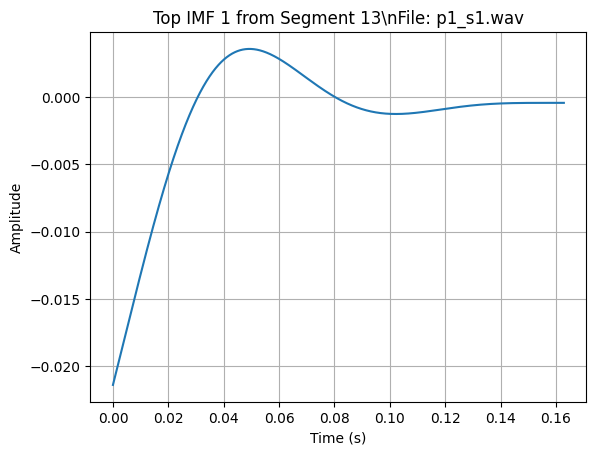

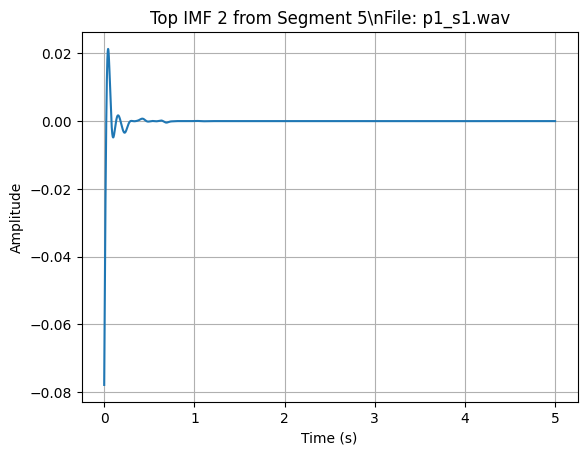

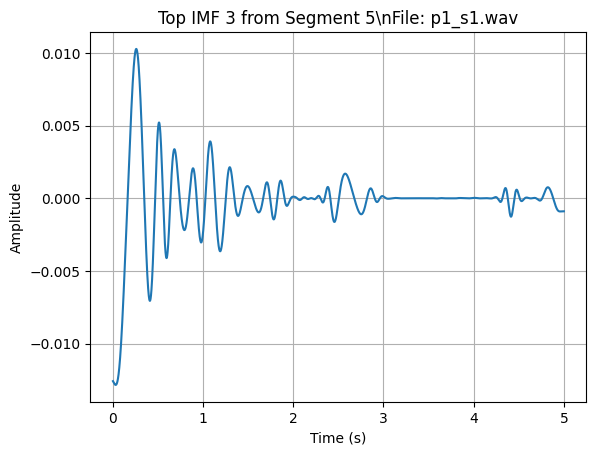

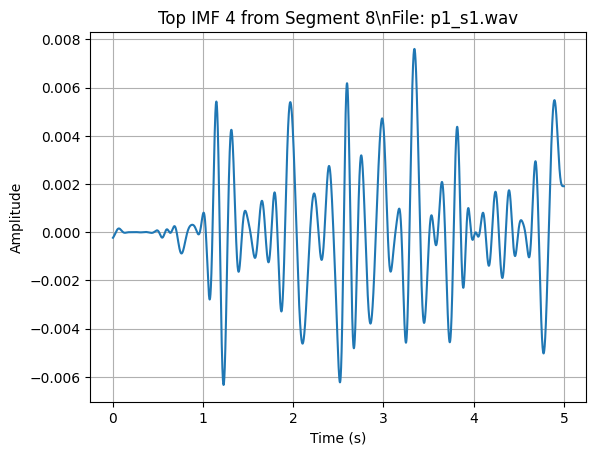

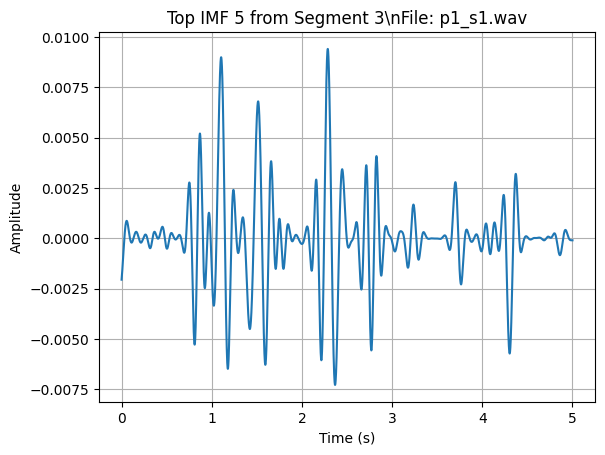

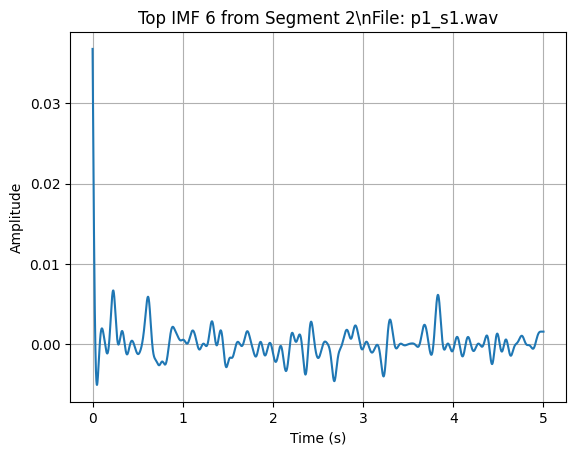

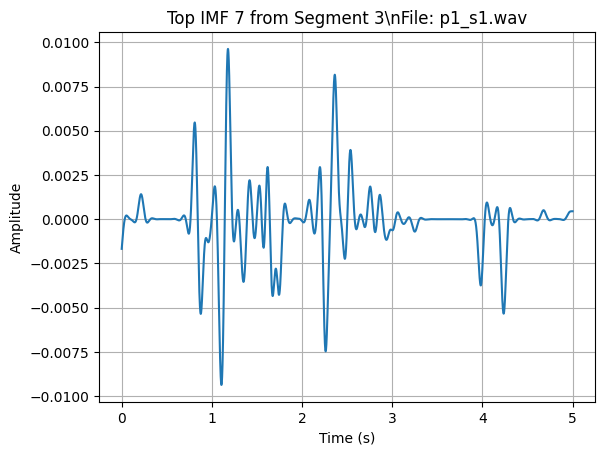

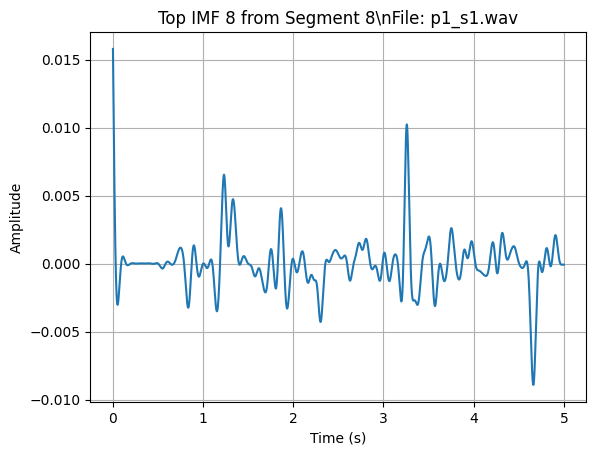

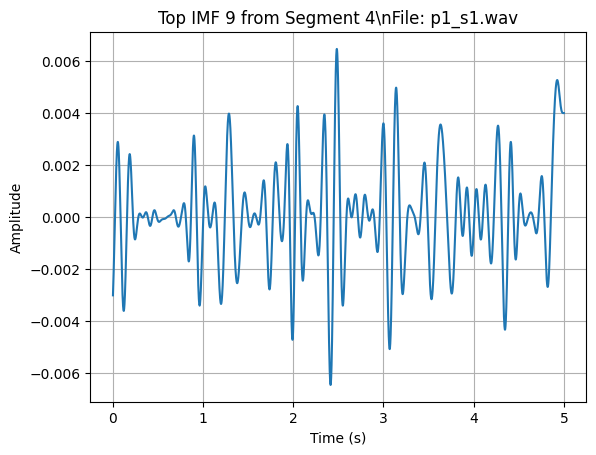

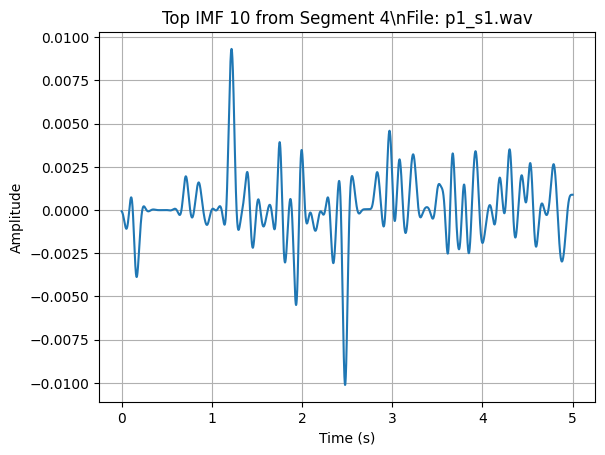

Analysis complete.


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, butter, filtfilt
from PyEMD import EMD
import pywt
import soundfile as sf

# -------------------------------------------------------------------------------------------
# Parameters
# -------------------------------------------------------------------------------------------
audio_file = 'p1_s1.wav'  # Replace with your audio file name
channel_to_process = 1        # Set to 0 or 1 depending on which channel to process
segment_duration = 5          # Segment length in seconds
fs = 2000  # Adjust this based on your audio file sampling rate

# -------------------------------------------------------------------------------------------
# Load the Recorded Audio File
# -------------------------------------------------------------------------------------------
audio_data, fs = sf.read(audio_file)  # Load your audio file
num_samples = len(audio_data)

# Validate the selected channel
if len(audio_data.shape) > 1:  # Check if the audio is multi-channel
    if channel_to_process >= audio_data.shape[1]:
        raise ValueError(f'The audio file does not have channel {channel_to_process + 1}.')
    selected_channel_data = audio_data[:, channel_to_process]
else:
    selected_channel_data = audio_data

# Define total duration of the audio
total_duration = num_samples / fs
num_segments = int(np.ceil(total_duration / segment_duration))

# Lists to store IMFs and their variances
all_imfs_fetal = []
all_imfs_variance = []

# -------------------------------------------------------------------------------------------
# Helper Functions
# -------------------------------------------------------------------------------------------
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# -------------------------------------------------------------------------------------------
# Process each 5-second segment independently and analyze
# -------------------------------------------------------------------------------------------
for seg in range(num_segments):
    # Define the start and end indices of the current segment
    start_idx = seg * segment_duration * fs
    end_idx = min((seg + 1) * segment_duration * fs, num_samples)

    # Ensure that start_idx and end_idx are integers
    start_idx = max(0, int(round(start_idx)))
    end_idx = min(num_samples, int(round(end_idx)))

    current_segment = selected_channel_data[start_idx:end_idx]

    # -------------------------------------------------------------------------------------------
    # Apply EMD to the Current Segment
    # -------------------------------------------------------------------------------------------
    try:
        # Remove DC Offset (Detrend)
        data = detrend(current_segment)

        # Perform Empirical Mode Decomposition (EMD)
        emd = EMD()
        imfs = emd(data)

        # Apply noise filtering on each IMF
        for j in range(imfs.shape[0]):
            # Low-pass filter each IMF to reduce high-frequency noise
            imfs[j, :] = lowpass_filter(imfs[j, :], 10, fs)

            # Apply wavelet denoising (Daubechies 4 wavelet)
            coeffs = pywt.wavedec(imfs[j, :], 'db4', level=4)
            threshold = 0.2 * np.median(np.abs(coeffs[-1]))
            coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
            imfs[j, :] = pywt.waverec(coeffs, 'db4')[:len(imfs[j, :])]

        # Store the IMFs for this segment in a list
        all_imfs_fetal.append(imfs)

        # Calculate and store the variance of each IMF
        variances = np.var(imfs, axis=1)
        all_imfs_variance.append(variances)
    except Exception as e:
        print(f'EMD failed for segment {seg + 1}: {str(e)}')
        continue

# -------------------------------------------------------------------------------------------
# Identify the Top 10 IMFs Based on Variance
# -------------------------------------------------------------------------------------------
imf_indices = []
all_variances_flattened = []

for seg, variances in enumerate(all_imfs_variance):
    for imf_idx, variance in enumerate(variances):
        imf_indices.append((seg, imf_idx))
        all_variances_flattened.append(variance)

# Combine indices with variances
imf_variance_data = list(zip(imf_indices, all_variances_flattened))
imf_variance_data = sorted(imf_variance_data, key=lambda x: x[1], reverse=True)  # Sort by variance

# Select the top 10 IMFs
top_10_imfs = imf_variance_data[:10]

# -------------------------------------------------------------------------------------------
# Display the Top IMFs in Separate Figures
# -------------------------------------------------------------------------------------------
for i, ((seg, imf_idx), variance) in enumerate(top_10_imfs):
    imfs = all_imfs_fetal[seg]
    t_imf = np.arange(len(imfs[imf_idx])) / fs  # Time vector for the IMF

    plt.figure()
    plt.plot(t_imf, imfs[imf_idx], linewidth=1.5)
    plt.title(f'Top IMF {i + 1} from Segment {seg + 1}\\nFile: {audio_file}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

print('Analysis complete.')


In [35]:
pip install numpy scipy matplotlib pyemd pywavelets soundfile


In [36]:
import numpy
import scipy
import matplotlib
import pyemd
import pywt
import soundfile


In [38]:
pip install EMD-signal


In [41]:

pip install PyEMD


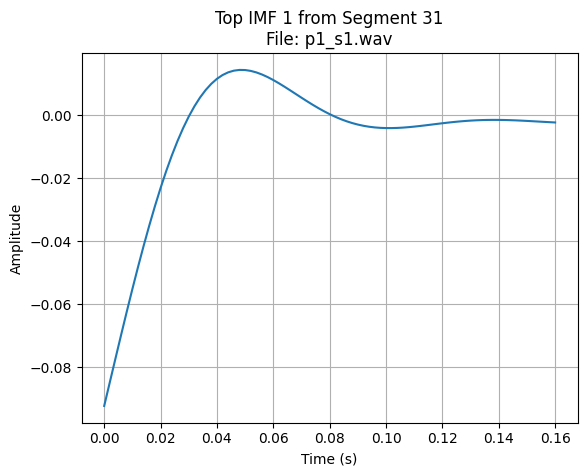

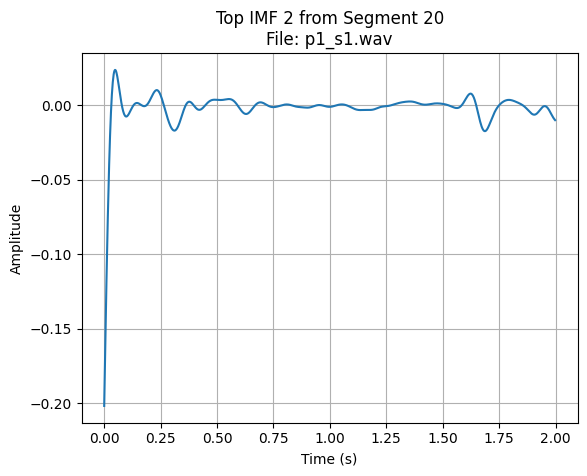

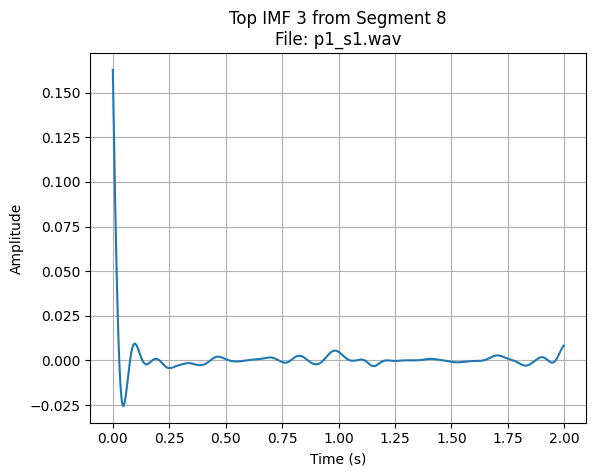

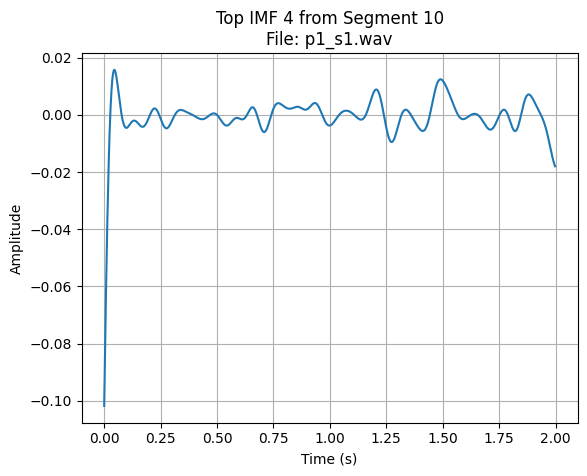

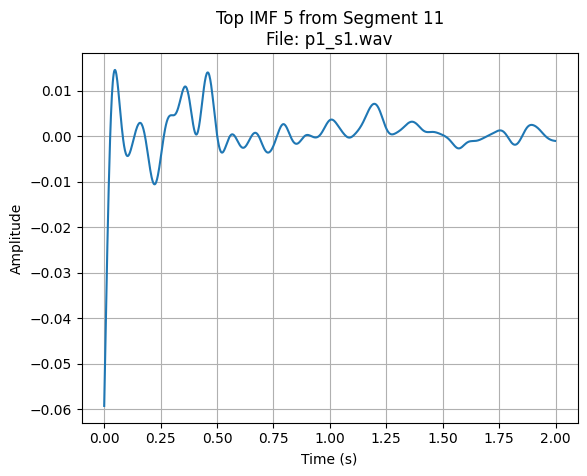

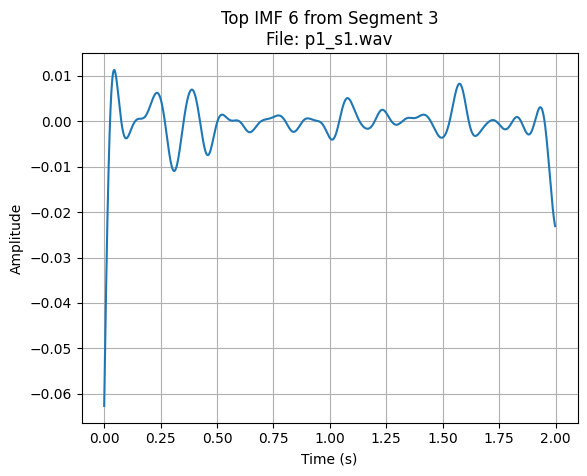

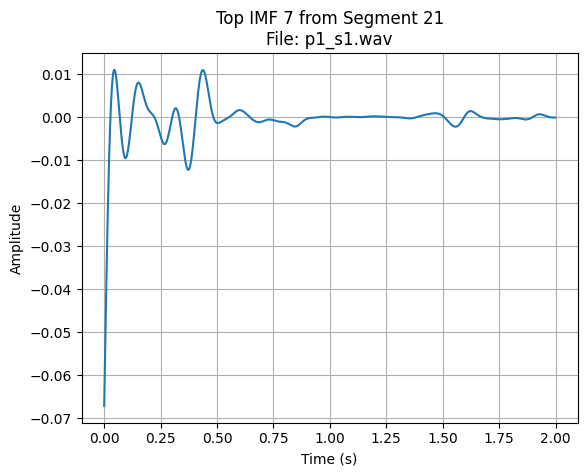

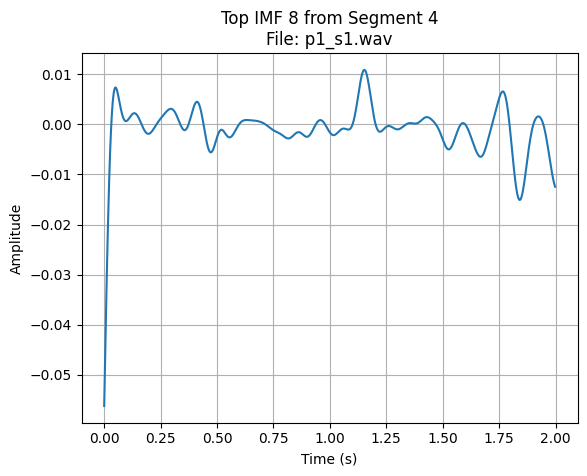

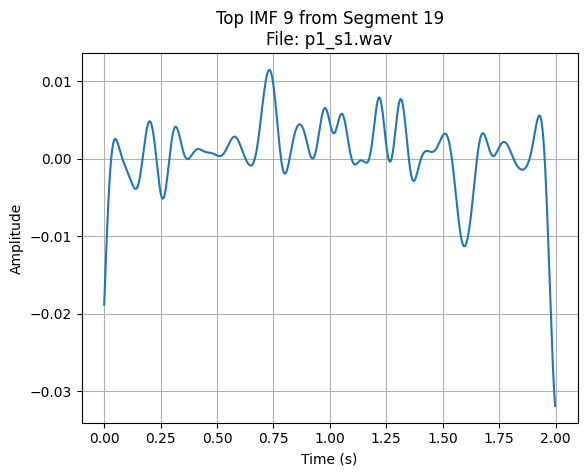

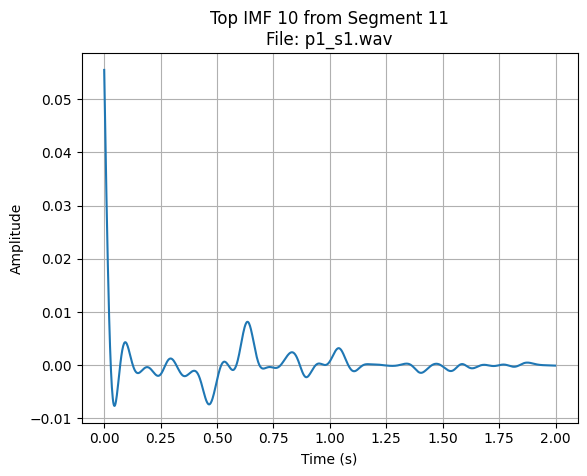

Analysis complete.


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, butter, filtfilt, resample
from PyEMD import EMD
import pywt
import soundfile as sf
from multiprocessing import Pool

# -------------------------------------------------------------------------------------------
# Parameters
# -------------------------------------------------------------------------------------------
audio_file = 'p1_s1.wav'  # Replace with your audio file name
channel_to_process = 0    # Set to 0 or 1 depending on which channel to process
segment_duration = 2      # Reduced segment length in seconds for faster processing
original_fs = 2000        # Original sampling frequency
new_fs = 500              # Downsampled frequency to reduce computation
lowpass_cutoff = 10       # Low-pass filter cutoff frequency
max_imfs = 5              # Limit the number of IMFs per segment

# -------------------------------------------------------------------------------------------
# Helper Functions
# -------------------------------------------------------------------------------------------
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def process_segment(segment_data):
    """Process a single audio segment."""
    try:
        # Remove DC Offset (Detrend)
        data = detrend(segment_data)

        # Perform Empirical Mode Decomposition (EMD)
        emd = EMD()
        emd.N_IMFS = max_imfs  # Limit the number of IMFs
        imfs = emd.emd(data)

        # Filter and denoise IMFs
        for j in range(imfs.shape[0]):
            # Low-pass filter to reduce high-frequency noise
            imfs[j, :] = lowpass_filter(imfs[j, :], lowpass_cutoff, new_fs)

            # Wavelet denoising with Daubechies wavelet
            coeffs = pywt.wavedec(imfs[j, :], 'db4', level=2)
            threshold = 0.2 * np.median(np.abs(coeffs[-1]))
            coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
            imfs[j, :] = pywt.waverec(coeffs, 'db4')[:len(imfs[j, :])]

        # Calculate variances of each IMF
        variances = np.var(imfs, axis=1)
        return imfs, variances
    except Exception as e:
        print(f"Error processing segment: {e}")
        return None, None

# -------------------------------------------------------------------------------------------
# Load and Preprocess Audio File
# -------------------------------------------------------------------------------------------
audio_data, fs = sf.read(audio_file)  # Load your audio file

# Select the appropriate channel
if len(audio_data.shape) > 1:  # Check if the audio is multi-channel
    if channel_to_process >= audio_data.shape[1]:
        raise ValueError(f'The audio file does not have channel {channel_to_process + 1}.')
    selected_channel_data = audio_data[:, channel_to_process]
else:
    selected_channel_data = audio_data

# Downsample the signal
selected_channel_data = resample(selected_channel_data, int(len(selected_channel_data) * new_fs / fs))
fs = new_fs  # Update sampling frequency after resampling

# Define total duration of the audio and number of segments
num_samples = len(selected_channel_data)
total_duration = num_samples / fs
num_segments = int(np.ceil(total_duration / segment_duration))

# -------------------------------------------------------------------------------------------
# Process Segments in Parallel
# -------------------------------------------------------------------------------------------
segment_data_list = [
    selected_channel_data[int(seg * segment_duration * fs):min(int((seg + 1) * segment_duration * fs), num_samples)]
    for seg in range(num_segments)
]

with Pool() as pool:
    results = pool.map(process_segment, segment_data_list)

all_imfs_fetal = [r[0] for r in results if r[0] is not None]
all_imfs_variance = [r[1] for r in results if r[1] is not None]

# -------------------------------------------------------------------------------------------
# Identify the Top 10 IMFs Based on Variance
# -------------------------------------------------------------------------------------------
imf_indices = []
all_variances_flattened = []

for seg, variances in enumerate(all_imfs_variance):
    for imf_idx, variance in enumerate(variances):
        imf_indices.append((seg, imf_idx))
        all_variances_flattened.append(variance)

# Combine indices with variances and sort by variance
imf_variance_data = list(zip(imf_indices, all_variances_flattened))
imf_variance_data = sorted(imf_variance_data, key=lambda x: x[1], reverse=True)

# Select the top 10 IMFs
top_10_imfs = imf_variance_data[:10]

# -------------------------------------------------------------------------------------------
# Display the Top IMFs
# -------------------------------------------------------------------------------------------
for i, ((seg, imf_idx), variance) in enumerate(top_10_imfs):
    imfs = all_imfs_fetal[seg]
    t_imf = np.arange(len(imfs[imf_idx])) / fs  # Time vector for the IMF

    plt.figure()
    plt.plot(t_imf, imfs[imf_idx], linewidth=1.5)
    plt.title(f'Top IMF {i + 1} from Segment {seg + 1}\nFile: {audio_file}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

print('Analysis complete.')


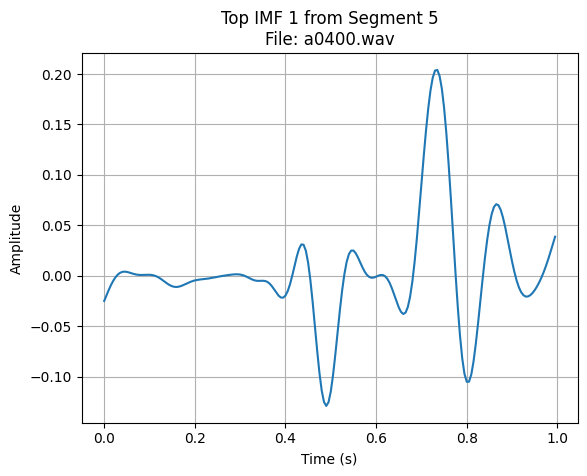

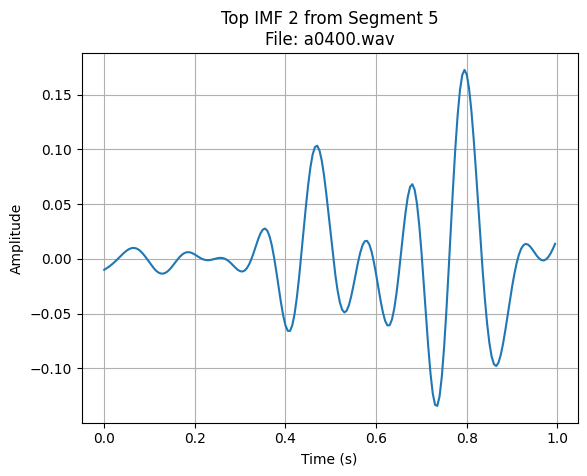

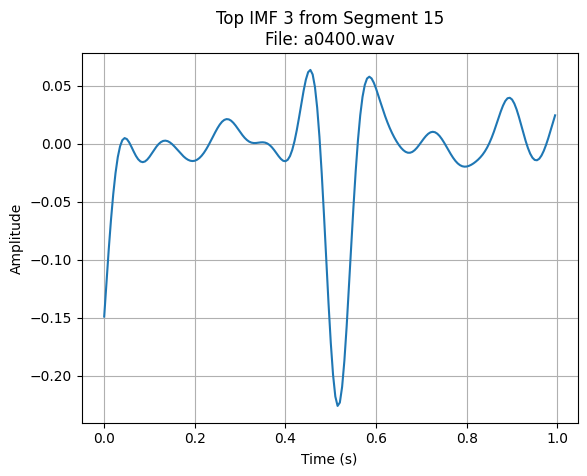

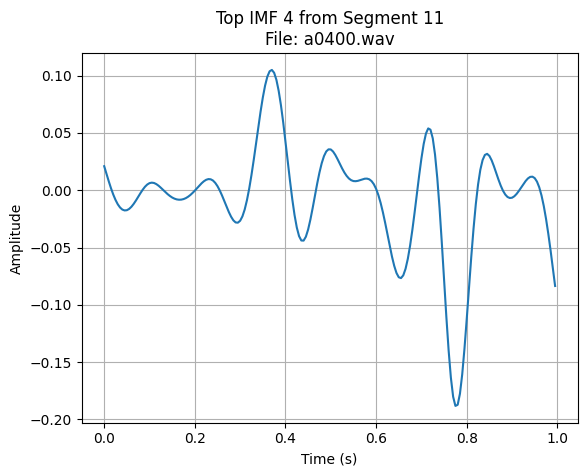

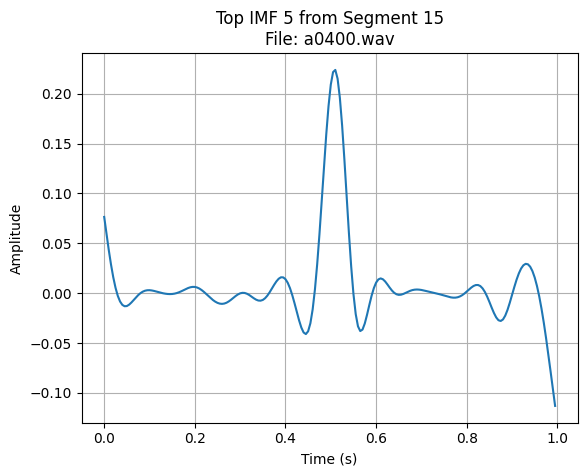

Analysis complete.


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, butter, filtfilt, resample
from PyEMD import EMD
import pywt
import soundfile as sf
from multiprocessing import Pool

# -------------------------------------------------------------------------------------------
# Parameters
# -------------------------------------------------------------------------------------------
audio_file = 'a0400.wav'  # Replace with your audio file name
channel_to_process = 0    # Set to 0 or 1 depending on which channel to process
segment_duration = 1      # Further reduced segment length in seconds
original_fs = 2000        # Original sampling frequency
new_fs = 200              # Lower downsample frequency
lowpass_cutoff = 10       # Low-pass filter cutoff frequency
max_imfs = 3              # Limit to 3 IMFs per segment

# -------------------------------------------------------------------------------------------
# Helper Functions
# -------------------------------------------------------------------------------------------
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def process_segment(segment_data):
    """Process a single audio segment."""
    try:
        # Remove DC Offset (Detrend)
        data = detrend(segment_data)

        # Perform Empirical Mode Decomposition (EMD)
        emd = EMD()
        emd.MAX_ITERATION = 100  # Limit iterations for faster processing
        emd.N_IMFS = max_imfs    # Limit number of IMFs
        imfs = emd.emd(data)

        # Filter and denoise IMFs
        for j in range(imfs.shape[0]):
            # Low-pass filter to reduce high-frequency noise
            imfs[j, :] = lowpass_filter(imfs[j, :], lowpass_cutoff, new_fs)

            # Wavelet denoising (Daubechies 4 wavelet)
            coeffs = pywt.wavedec(imfs[j, :], 'db4', level=1)  # Reduced decomposition level
            threshold = 0.2 * np.median(np.abs(coeffs[-1]))
            coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
            imfs[j, :] = pywt.waverec(coeffs, 'db4')[:len(imfs[j, :])]

        # Calculate variances of each IMF
        variances = np.var(imfs, axis=1)
        return imfs, variances
    except Exception as e:
        print(f"Error processing segment: {e}")
        return None, None

# -------------------------------------------------------------------------------------------
# Load and Preprocess Audio File
# -------------------------------------------------------------------------------------------
audio_data, fs = sf.read(audio_file)  # Load your audio file

# Select the appropriate channel
if len(audio_data.shape) > 1:  # Check if the audio is multi-channel
    if channel_to_process >= audio_data.shape[1]:
        raise ValueError(f'The audio file does not have channel {channel_to_process + 1}.')
    selected_channel_data = audio_data[:, channel_to_process]
else:
    selected_channel_data = audio_data

# Downsample the signal
selected_channel_data = resample(selected_channel_data, int(len(selected_channel_data) * new_fs / fs))
fs = new_fs  # Update sampling frequency after resampling

# Define total duration of the audio and number of segments
num_samples = len(selected_channel_data)
total_duration = num_samples / fs
num_segments = int(np.ceil(total_duration / segment_duration))

# -------------------------------------------------------------------------------------------
# Process Segments in Parallel
# -------------------------------------------------------------------------------------------
segment_data_list = [
    selected_channel_data[int(seg * segment_duration * fs):min(int((seg + 1) * segment_duration * fs), num_samples)]
    for seg in range(num_segments)
]

with Pool() as pool:
    results = pool.map(process_segment, segment_data_list)

all_imfs_fetal = [r[0] for r in results if r[0] is not None]
all_imfs_variance = [r[1] for r in results if r[1] is not None]

# -------------------------------------------------------------------------------------------
# Identify the Top 10 IMFs Based on Variance
# -------------------------------------------------------------------------------------------
imf_indices = []
all_variances_flattened = []

for seg, variances in enumerate(all_imfs_variance):
    for imf_idx, variance in enumerate(variances):
        imf_indices.append((seg, imf_idx))
        all_variances_flattened.append(variance)

# Combine indices with variances and sort by variance
imf_variance_data = list(zip(imf_indices, all_variances_flattened))
imf_variance_data = sorted(imf_variance_data, key=lambda x: x[1], reverse=True)

# Select the top 5 IMFs (Reduced to save runtime)
top_5_imfs = imf_variance_data[:5]

# -------------------------------------------------------------------------------------------
# Display the Top IMFs
# -------------------------------------------------------------------------------------------
for i, ((seg, imf_idx), variance) in enumerate(top_5_imfs):
    imfs = all_imfs_fetal[seg]
    t_imf = np.arange(len(imfs[imf_idx])) / fs  # Time vector for the IMF

    plt.figure()
    plt.plot(t_imf, imfs[imf_idx], linewidth=1.5)
    plt.title(f'Top IMF {i + 1} from Segment {seg + 1}\nFile: {audio_file}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

print('Analysis complete.')


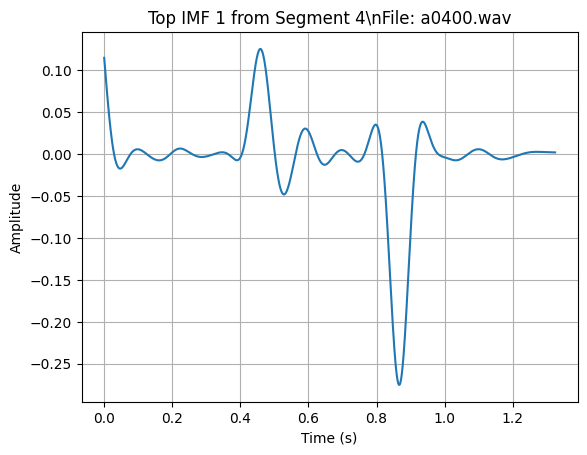

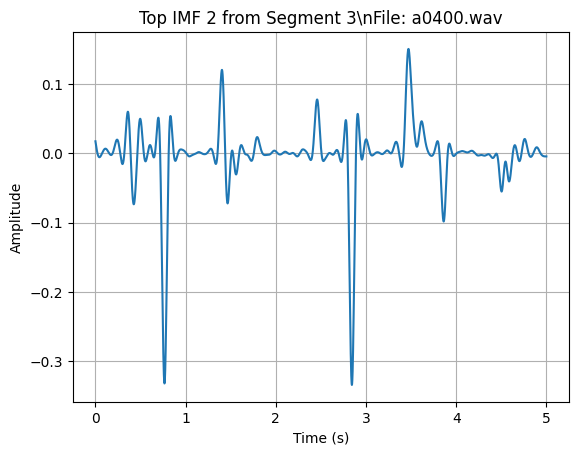

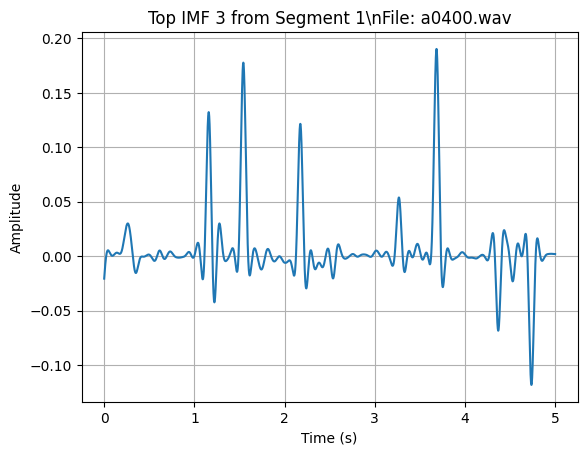

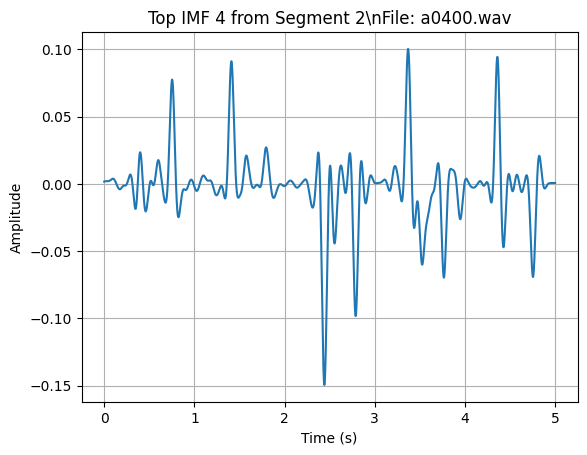

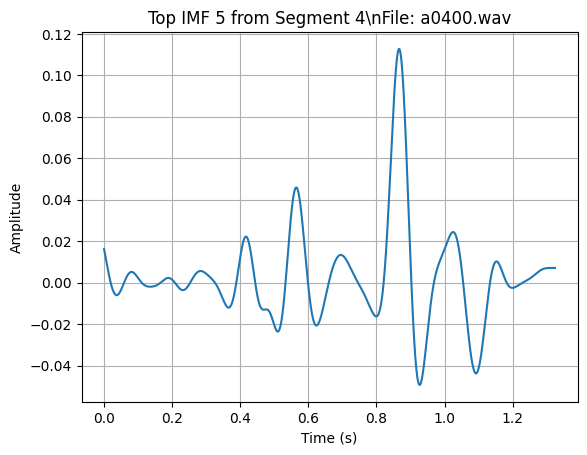

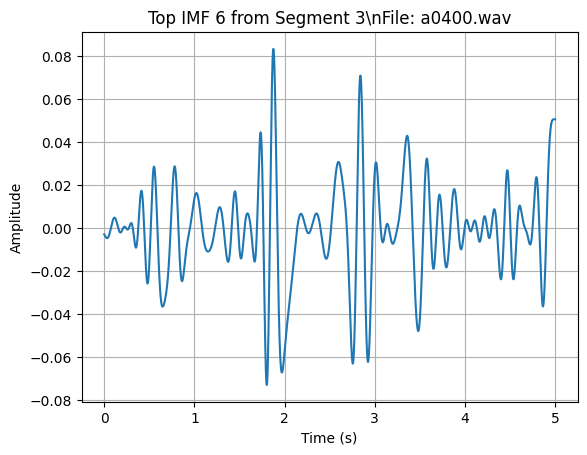

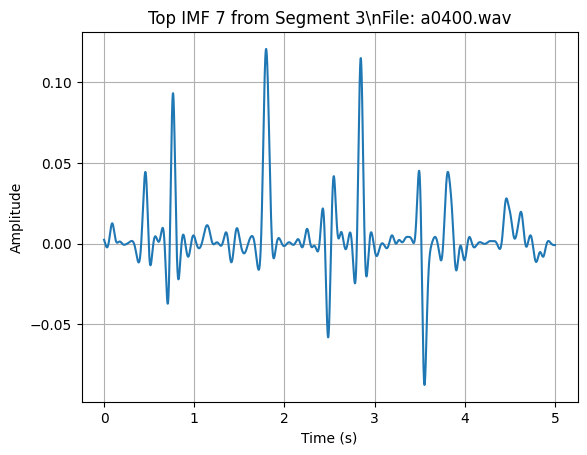

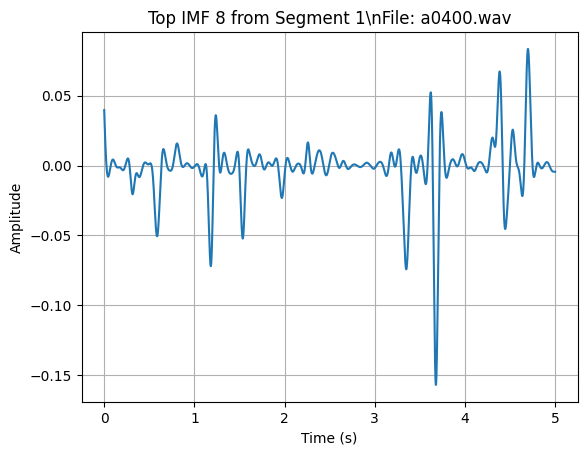

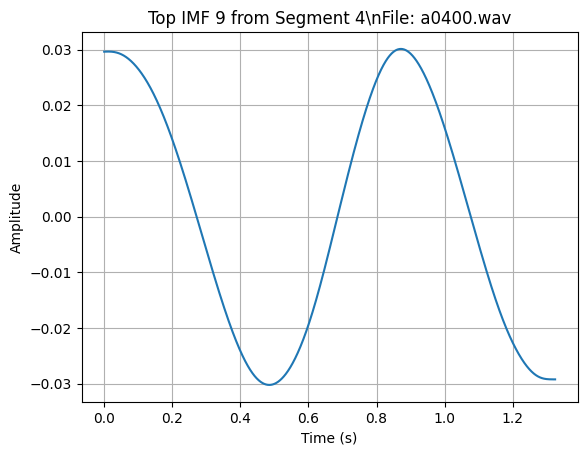

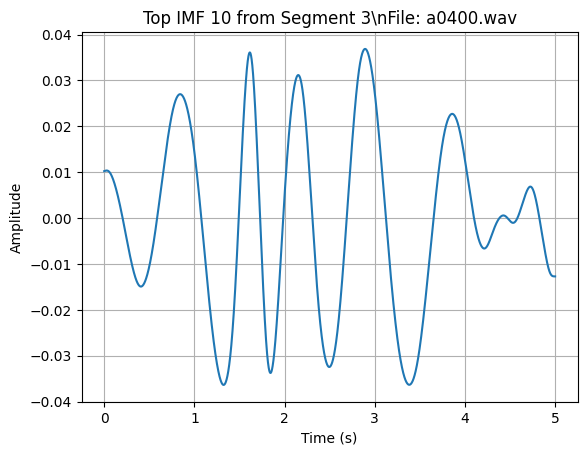

Analysis complete.


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, butter, filtfilt
from PyEMD import EMD
import pywt
import soundfile as sf

# -------------------------------------------------------------------------------------------
# Parameters
# -------------------------------------------------------------------------------------------
audio_file = 'a0400.wav'  # Replace with your audio file name
channel_to_process = 1        # Set to 0 or 1 depending on which channel to process
segment_duration = 5          # Segment length in seconds
fs = 2000  # Adjust this based on your audio file sampling rate

# -------------------------------------------------------------------------------------------
# Load the Recorded Audio File
# -------------------------------------------------------------------------------------------
audio_data, fs = sf.read(audio_file)  # Load your audio file
num_samples = len(audio_data)

# Validate the selected channel
if len(audio_data.shape) > 1:  # Check if the audio is multi-channel
    if channel_to_process >= audio_data.shape[1]:
        raise ValueError(f'The audio file does not have channel {channel_to_process + 1}.')
    selected_channel_data = audio_data[:, channel_to_process]
else:
    selected_channel_data = audio_data

# Define total duration of the audio
total_duration = num_samples / fs
num_segments = int(np.ceil(total_duration / segment_duration))

# Lists to store IMFs and their variances
all_imfs_fetal = []
all_imfs_variance = []

# -------------------------------------------------------------------------------------------
# Helper Functions
# -------------------------------------------------------------------------------------------
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# -------------------------------------------------------------------------------------------
# Process each 5-second segment independently and analyze
# -------------------------------------------------------------------------------------------
for seg in range(num_segments):
    # Define the start and end indices of the current segment
    start_idx = seg * segment_duration * fs
    end_idx = min((seg + 1) * segment_duration * fs, num_samples)

    # Ensure that start_idx and end_idx are integers
    start_idx = max(0, int(round(start_idx)))
    end_idx = min(num_samples, int(round(end_idx)))

    current_segment = selected_channel_data[start_idx:end_idx]

    # -------------------------------------------------------------------------------------------
    # Apply EMD to the Current Segment
    # -------------------------------------------------------------------------------------------
    try:
        # Remove DC Offset (Detrend)
        data = detrend(current_segment)

        # Perform Empirical Mode Decomposition (EMD)
        emd = EMD()
        imfs = emd(data)

        # Apply noise filtering on each IMF
        for j in range(imfs.shape[0]):
            # Low-pass filter each IMF to reduce high-frequency noise
            imfs[j, :] = lowpass_filter(imfs[j, :], 10, fs)

            # Apply wavelet denoising (Daubechies 4 wavelet)
            coeffs = pywt.wavedec(imfs[j, :], 'db4', level=4)
            threshold = 0.2 * np.median(np.abs(coeffs[-1]))
            coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
            imfs[j, :] = pywt.waverec(coeffs, 'db4')[:len(imfs[j, :])]

        # Store the IMFs for this segment in a list
        all_imfs_fetal.append(imfs)

        # Calculate and store the variance of each IMF
        variances = np.var(imfs, axis=1)
        all_imfs_variance.append(variances)
    except Exception as e:
        print(f'EMD failed for segment {seg + 1}: {str(e)}')
        continue

# -------------------------------------------------------------------------------------------
# Identify the Top 10 IMFs Based on Variance
# -------------------------------------------------------------------------------------------
imf_indices = []
all_variances_flattened = []

for seg, variances in enumerate(all_imfs_variance):
    for imf_idx, variance in enumerate(variances):
        imf_indices.append((seg, imf_idx))
        all_variances_flattened.append(variance)

# Combine indices with variances
imf_variance_data = list(zip(imf_indices, all_variances_flattened))
imf_variance_data = sorted(imf_variance_data, key=lambda x: x[1], reverse=True)  # Sort by variance

# Select the top 10 IMFs
top_10_imfs = imf_variance_data[:10]

# -------------------------------------------------------------------------------------------
# Display the Top IMFs in Separate Figures
# -------------------------------------------------------------------------------------------
for i, ((seg, imf_idx), variance) in enumerate(top_10_imfs):
    imfs = all_imfs_fetal[seg]
    t_imf = np.arange(len(imfs[imf_idx])) / fs  # Time vector for the IMF

    plt.figure()
    plt.plot(t_imf, imfs[imf_idx], linewidth=1.5)
    plt.title(f'Top IMF {i + 1} from Segment {seg + 1}\\nFile: {audio_file}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

print('Analysis complete.')
